<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics, losses
import tensorflow as tf
from keras import backend as K
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

In [11]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Sampling Layer


We sample a point **z** from the latent distribution using the following equation:

z = z_mean + z_sigma * epsilon

where z_sigma = exp(z_log_var * 0.5) and epsilon ~ N(0, I)



In [12]:
# creating new layer by subclassing Keras Layer class
# (can then be used in VAE network)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # The reparameterization Trick!

# Encoder


In [19]:
encoder_input = layers.Input(shape=(32, 32, 1), name = "encoder_input")
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

# flatten layer is directly connected z_mean and z_log_var layers
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
# calling the sampling layer created above to sample from the latent space
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

In [14]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 14, 14, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                                                            

# Decoder

In [15]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides = 1,
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output)

# Creating VAE and training the VAE

In [20]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    # fucntion that outputs VAE output for prediction
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis = 1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(
    x_train,
    epochs=5,
    batch_size=100
)

Epoch 1/5
600/600 [==============================] - 206s 342ms/step - total_loss: 151.1842 - reconstruction_loss: 146.6524 - kl_loss: 4.5318
Epoch 2/5
600/600 [==============================] - 204s 339ms/step - total_loss: 134.3505 - reconstruction_loss: 129.4468 - kl_loss: 4.9038
Epoch 3/5
600/600 [==============================] - 197s 329ms/step - total_loss: 133.0324 - reconstruction_loss: 128.0298 - kl_loss: 5.0027
Epoch 4/5
600/600 [==============================] - 203s 339ms/step - total_loss: 132.2990 - reconstruction_loss: 127.2251 - kl_loss: 5.0741
Epoch 5/5
600/600 [==============================] - 188s 314ms/step - total_loss: 131.7088 - reconstruction_loss: 126.5556 - kl_loss: 5.1531


# Generating non-novel images

In [31]:
example_images = x_test[:5000]
z_mean, z_log_var, reconstructions = vae.predict(example_images)

157/157 [==============================] - 9s 58ms/step


In [32]:
reconstructions.shape

(5000, 32, 32, 1)

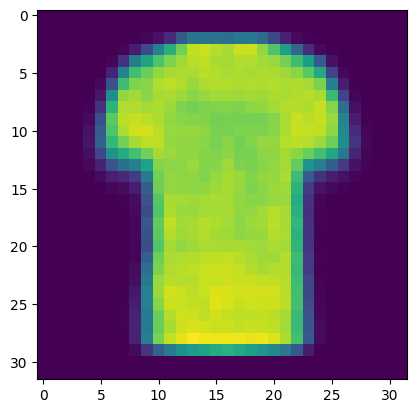

In [39]:
import matplotlib.pyplot as plt
plt.imshow(reconstructions[400, :, :, :])

# Visualizing the Latent Space

In [ ]:
embeddings = encoder.predict(example_images)
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)

# Generating novel images using the decoder

In [40]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [41]:
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 1s 670ms/step


In [42]:
reconstructions.shape

(18, 32, 32, 1)

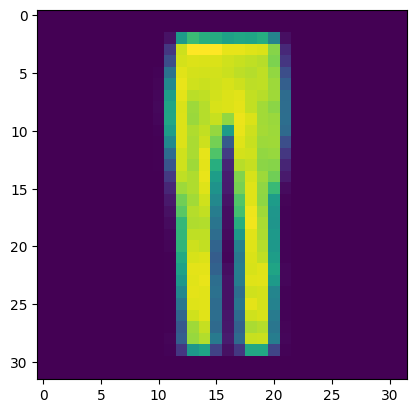

In [61]:
plt.imshow(reconstructions[17, :, :, 0])

# Multi-Dimensional Latent Space VAE


---



# Loading Celeb Faces, Preprocess and imports

In [62]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

In [63]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200 # latent space dimension is 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

OSError: ignored